In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import hemcee

from likelihood import LogLikelihood
from velocity import velocity

import matplotlib.pyplot as plt

/var/folders/wd/zr_by8q96891mxc_506sm9sr0000gn/T/ipykernel_20860/3699973129.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "+k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')


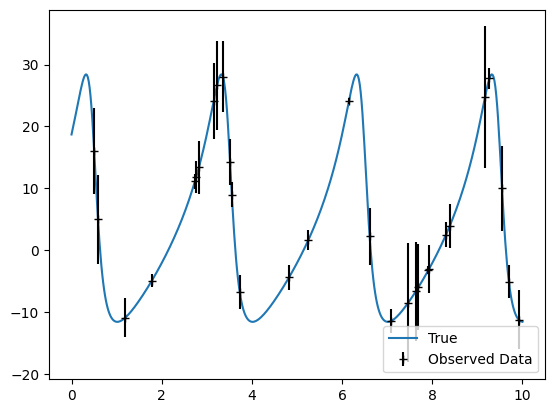

In [3]:
seed = 0
key = jax.random.PRNGKey(seed)
keys = jax.random.split(key, 4)

tf = 10
t = jnp.linspace(0, tf, 500)  # 500 time points over 10 days

# Orbital parameters
period = 3.0          # Orbital period in days
eccentricity = 0.50    # Moderate eccentricity (0 <= ecc < 1)
omega = 1.0          # Argument of periastron in radians 
phi0 = 1.0            # Phase offset (in radians)
K = 20.0              # Semi-amplitude of velocity in m/s
v0 = 0.0              # Systemic velocity offset in m/s

initial_params = jnp.array([period, eccentricity, omega, phi0, K, v0])

# True Data
rv_true = velocity(t, period, eccentricity, omega, phi0, K, v0)

# Observed Data
n_observed = 30
time_obs = jnp.sort(jax.random.uniform(keys[0], minval=0, maxval=tf, shape=(n_observed)))
rv_err = 5 * jnp.abs(jax.random.normal(keys[1], shape=(len(time_obs),)))
rv_obs = velocity(time_obs, period, eccentricity, omega, phi0, K, v0) 


plt.plot(t, rv_true, label="True ")
plt.errorbar(time_obs, rv_obs, yerr=rv_err, fmt="+k", label="Observed Data", color='black')
plt.legend(loc='lower right')
plt.show()


# Marginalize the Likelihood

Compute the marginalized likelihood
$$
p(D | \theta) = \mathbb E_{(\omega, \phi_0) \sim \mu_H} [p(D | \theta, \omega, \phi_0) ]
$$4

In [4]:
likelihood = LogLikelihood(time_obs, rv_obs, rv_err)

In [5]:
from jax.scipy.special import logsumexp

def sample_torus(key: jax.random.PRNGKey, n_samples: int):
    """Uniformly samples (omega, phi0) from torus"""
    points = jax.random.uniform(key, minval=0, maxval=2*jnp.pi, shape=(n_samples, 2))
    omega = points[:, 0]
    phi0 = points[:, 1]
    return omega, phi0

class MCMCMarginalizedLogLikelihood:
    def __init__(self, 
                 key: jax.random.PRNGKey, 
                 likelihood: LogLikelihood,
                 n_samples: int = 100):
        """Precompute samples on the torus so the marginalized likelihood is deterministic
        for the sampler (avoids reusing or misusing a PRNG key inside __call__)."""
        self.likelihood = likelihood
        self.n_samples = n_samples
        # Pre-generate (omega, phi0) samples once and reuse
        omega_samples, phi0_samples = sample_torus(key, self.n_samples)
        self.omega_samples = omega_samples
        self.phi0_samples = phi0_samples

    def __call__(self, params: jnp.ndarray,) -> float:
        """
        Computes the marginalized log-likelihood by averaging over precomputed samples of (omega, phi0).

        Args:
            params: array of shape (4,) containing [period, eccentricity, K, v0]
        Returns:
            scalar marginalized log-likelihood (jax scalar)
        """
        def func(omega, phi0):
            full_params = jnp.array([params[0], params[1], omega, phi0, params[2], params[3]])
            return self.likelihood(full_params)
        log_likelihoods = jax.vmap(func)(self.omega_samples, self.phi0_samples)
        # log-sum-exp over the samples, then subtract log(N) to get log(1/N * sum p)
        marginalized_log_likelihood = logsumexp(log_likelihoods) - jnp.log(self.n_samples)
        return marginalized_log_likelihood

In [6]:
log_prob_marginal = MCMCMarginalizedLogLikelihood(keys[2], likelihood, n_samples=100)

$$
\mathbb E[p] = \frac{1}{N}\sum_i \exp(\log p(x_i))
$$

In [10]:
dim = 4
total_chains = 20
sampler = hemcee.EnsembleSampler(total_chains=total_chains, dim=dim, log_prob=log_prob_marginal)

In [ ]:
inital_state = jax.random.uniform(
    keys[3], 
    minval=jnp.array([1.0, 0.0, 10.0, -10.0]), 
    maxval=jnp.array([10.0, 0.9, 30.0, 10.0]), 
    shape=(total_chains, dim))

print(inital_state.shape)

samples = sampler.run_mcmc(
    jax.random.PRNGKey(1), 
    initial_state=inital_state,
    num_samples=10**4,
    warmup=10**3,
    thin_by=5)

print('Acceptance rates of chains:')
print(sampler.diagnostics_main['acceptance_rate'])

# You can compare the performance of different moves 
# by computing the integrated autocorrelation time
tau = hemcee.autocorr.integrated_time(samples)
print('Integrated autocorrelation time:')
print(tau)

(20, 4)
Using 20 total chains: Group 1 (10), Group 2 (10)
Acceptance rates of chains:


In [ ]:
samples